Seeding for reproducibility

In [16]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

Importing the dependencies

In [17]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

Data Curation

Upload the kaggle.json file

In [18]:
!pip install kaggle


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
kaggle_credentials = json.load(open("kaggle.json"))

In [20]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

In [21]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0




  0%|          | 0.00/2.04G [00:00<?, ?B/s]
  0%|          | 1.00M/2.04G [00:01<48:27, 753kB/s]
  0%|          | 2.00M/2.04G [00:01<23:57, 1.52MB/s]
  0%|          | 3.00M/2.04G [00:01<14:52, 2.45MB/s]
  0%|          | 5.00M/2.04G [00:01<08:18, 4.38MB/s]
  0%|          | 6.00M/2.04G [00:02<07:00, 5.19MB/s]
  0%|          | 7.00M/2.04G [00:02<06:19, 5.75MB/s]
  0%|          | 9.00M/2.04G [00:02<04:39, 7.80MB/s]
  1%|          | 11.0M/2.04G [00:02<03:44, 9.70MB/s]
  1%|          | 13.0M/2.04G [00:02<03:25, 10.6MB/s]
  1%|          | 15.0M/2.04G [00:02<03:22, 10.8MB/s]
  1%|          | 17.0M/2.04G [00:02<03:15, 11.1MB/s]
  1%|          | 19.0M/2.04G [00:03<03:06, 11.6MB/s]
  1%|          | 21.0M/2.04G [00:03<03:04, 11.8MB/s]
  1%|          | 23.0M/2.04G [00:03<03:00, 12.0MB/s]
  1%|          | 25.0M/2.04G [00:03<03:00, 12.0MB/s]
  1%|▏         | 27.0M/2.04G [00:03<03:05, 11.7MB/s]
  1%|▏         | 29.0M/2.04G [00:03<03:01, 11.9MB/s]
  1%|▏         | 31.0M/2.04G [00:04<02:58, 12.1MB/s]
  

In [22]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
# Unzip the downloaded dataset
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [24]:
print(os.listdir("plantvillage dataset"))


print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['color', 'grayscale', 'segmented']
38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']
38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']
38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


Number of Classes = 38

In [25]:
print(len(os.listdir("plantvillage dataset/color/Grape___healthy")))
print(os.listdir("plantvillage dataset/color/Grape___healthy")[:5])

423
['00e00912-bf75-4cf8-8b7d-ad64b73bea5f___Mt.N.V_HL 6067.JPG', '0163a6aa-fbf8-47c5-965f-59b6efe8bfe5___Mt.N.V_HL 6103.JPG', '0294ca65-4c29-44be-af28-501df9f715e8___Mt.N.V_HL 6176.JPG', '02f95acb-5d92-4f2a-b7ec-3af8709ee7c9___Mt.N.V_HL 9078.JPG', '03027791-26bb-4c46-960e-8df76e27042c___Mt.N.V_HL 6070.JPG']


Data Preprocessing

In [26]:
# Dataset Path
base_dir = 'plantvillage dataset/color'

(256, 256, 3)


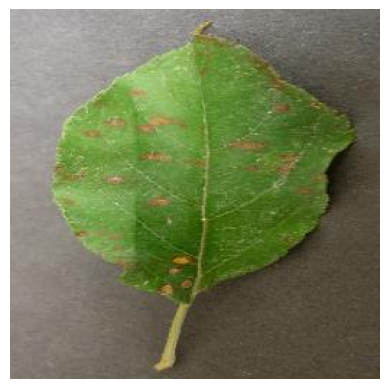

In [28]:
image_path = 'plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [29]:
image_path = 'plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img)

[[[179 175 176]
  [181 177 178]
  [184 180 181]
  ...
  [115 112 105]
  [108 105  98]
  [101  98  91]]

 [[176 172 173]
  [177 173 174]
  [178 174 175]
  ...
  [113 110 103]
  [111 108 101]
  [109 106  99]]

 [[180 176 177]
  [180 176 177]
  [180 176 177]
  ...
  [108 105  98]
  [111 108 101]
  [114 111 104]]

 ...

 [[137 128 119]
  [131 122 113]
  [125 116 107]
  ...
  [ 74  65  48]
  [ 74  65  48]
  [ 73  64  47]]

 [[136 127 118]
  [132 123 114]
  [128 119 110]
  ...
  [ 77  69  50]
  [ 75  67  48]
  [ 75  67  48]]

 [[133 124 115]
  [133 124 115]
  [132 123 114]
  ...
  [ 81  73  54]
  [ 80  72  53]
  [ 79  71  52]]]


In [30]:
# Image Parameters
img_size = 224
batch_size = 32

Train Test Split

In [31]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [32]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [33]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


Convolutional Neural Network

In [34]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

c:\Users\Valmik Belgaonkar\OneDrive\Desktop\GIS-Plant-Disease-Classification\plantenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,805,158 (182.36 MB)

 Trainable params: 47,805,158 (182.36 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/5


c:\Users\Valmik Belgaonkar\OneDrive\Desktop\GIS-Plant-Disease-Classification\plantenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 11890s 9s/step - accuracy: 0.6076 - loss: 1.8575 - val_accuracy: 0.8256 - val_loss: 0.5358
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3481
Epoch 3/5


C:\Users\Valmik Belgaonkar\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1858s 1s/step - accuracy: 0.9202 - loss: 0.2523 - val_accuracy: 0.8568 - val_loss: 0.4750
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 2.6345e-05
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 795s 585ms/step - accuracy: 0.9689 - loss: 0.0981 - val_accuracy: 0.8645 - val_loss: 0.4939


Model Evaluation

In [38]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
339/339 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.8674 - loss: 0.4759
Validation Accuracy: 86.45%


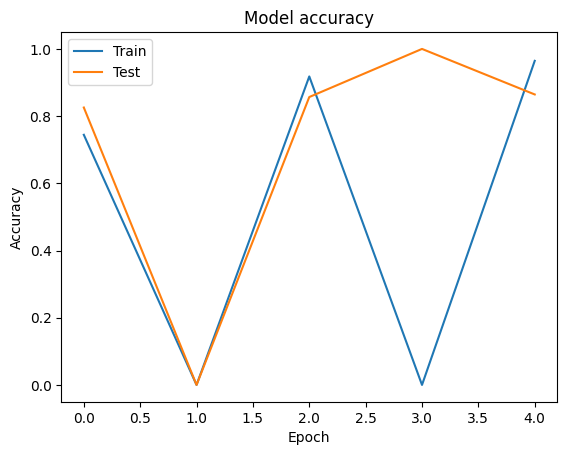

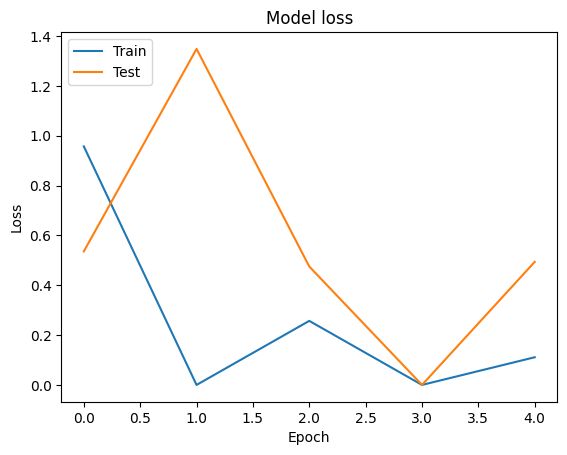

In [39]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Building a Predictive System

In [40]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [41]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [42]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [43]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [49]:
# Example Usage
image_path = 'test_apple_black_rot.JPG'
#image_path = '/content/test_blueberry_healthy.jpg'
#image_path = '/content/test_potato_early_blight.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Valmik Belgaonkar\\OneDrive\\Desktop\\GIS-Plant-Disease-Classification\\ML_Model\\test_apple_black_rot.JPG'

Save the model to local

In [47]:
model.save('plant_disease_prediction_model.h5')